In [42]:
%load_ext autoreload
%autoreload 2
import numpy as np
from utils import get_summits, get_shifts, one_hot, GCregress
import scipy.stats
import h5py
import matplotlib.pyplot as plt

ctype = 'iPSC'
strain = 'spret'
ident = ''

basedir = '/data/leslie/sunge'
datadir = f'{basedir}/f1_ASA/{strain}/{ctype}/data/'
name = ['train', 'val', 'test']
seqlen = 300
seqlen1 = 150

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
# Start afresh, load your noGC data
x = dict()
y = dict()
with h5py.File(datadir+'data_noGC'+ident+'.h5','r') as f:
    for n in name:
        for allele in ['b6', strain]:
            x[n+'_'+allele] = f['x_'+n+'_'+allele][()]
            y[n+'_'+allele] = f['y_'+n+'_'+allele][()]
            if n!='test':
                x[n+'_'+allele+'_unegs'] = f['x_'+n+'_'+allele+'_unegs'][()]
        if n!='test':
            y[n+'_unegs'] = f['y_'+n+'_unegs'][()]

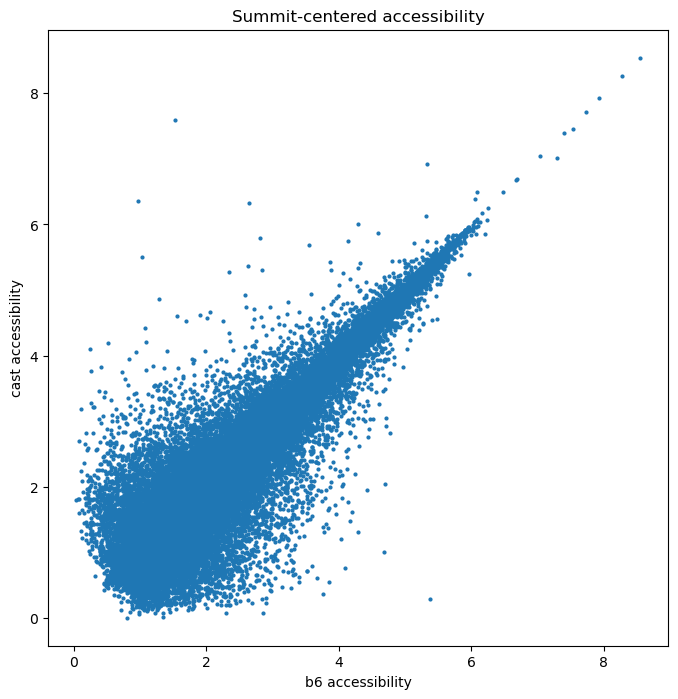

In [17]:
# Visualize allele-specific coverage before correction

fig = plt.figure(figsize = (8, 8))
ax = fig.add_subplot()

ax.scatter(y['train_b6'], y[f'train_{strain}'], s=4)
plt.title('Summit-centered accessibility')
ax.set_xlabel('b6 accessibility')
ax.set_ylabel(f'{strain} accessibility')
plt.show()

In [44]:
temp_x = np.vstack([x[k] for k in x.keys() if 'unegs' not in k])
temp_y = np.concatenate([y[k] for k in y.keys() if 'unegs' not in k])

# Compute GC content for pre-correction plot
GC = np.sum(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
GC = GC[:,1]+GC[:,2]
pear1, p_p1 = scipy.stats.pearsonr(GC, temp_y)
spear1, s_p1 = scipy.stats.spearmanr(GC, temp_y)

# GC regression
coef = GCregress(temp_x[:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], temp_y)
new_y = temp_y - coef*GC
pear2, p_p2 = scipy.stats.pearsonr(GC, new_y)
spear2, s_p2 = scipy.stats.spearmanr(GC, new_y)

# Print correlations before and after regression
print(f'Pearson Pre-Correction: {pear1}, {p_p1}')
print(f'Pearson Post_Correction: {pear2}, {p_p2}')
print(f'Spearman Pre-Correction: {spear1}, {s_p1}')
print(f'Spearman Post_Correction: {spear2}, {s_p2}')

Pearson Pre-Correction: 0.392387700933729, 0.0
Pearson Post_Correction: 2.2833297752544723e-16, 1.0000000000632863
Spearman Pre-Correction: 0.3636953006746089, 0.0
Spearman Post_Correction: -0.015836898609964418, 2.095430535416425e-09


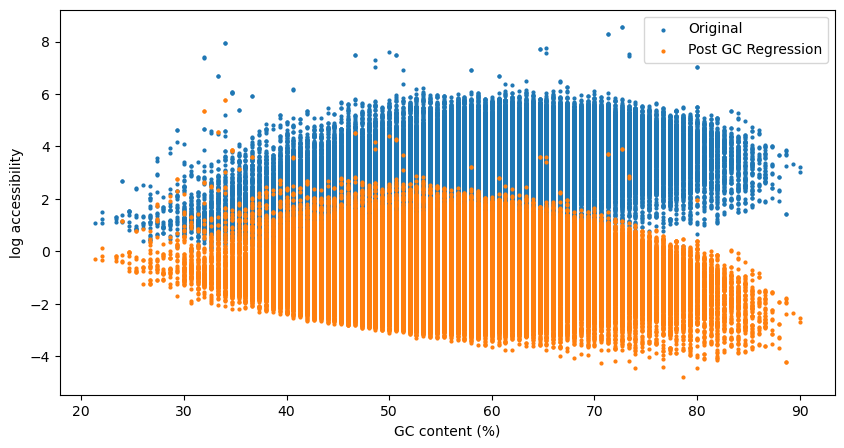

In [16]:
# Visualize GC-count relationship
fig = plt.figure(figsize = (10, 5))
ax = fig.add_subplot()

ax.scatter(GC/seqlen1 * 100, temp_y, s=4, label="Original")
ax.scatter(GC/seqlen1 * 100, new_y, s=4, label = "Post GC Regression")

ax.set_xlabel('GC content (%)')
ax.set_ylabel('log accessibility')
ax.legend()
plt.show()

/scratch/lsftmp/19423695.tmpdir/ipykernel_30420/1894276458.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(y['train_b6'], y[f'train_{strain}'],


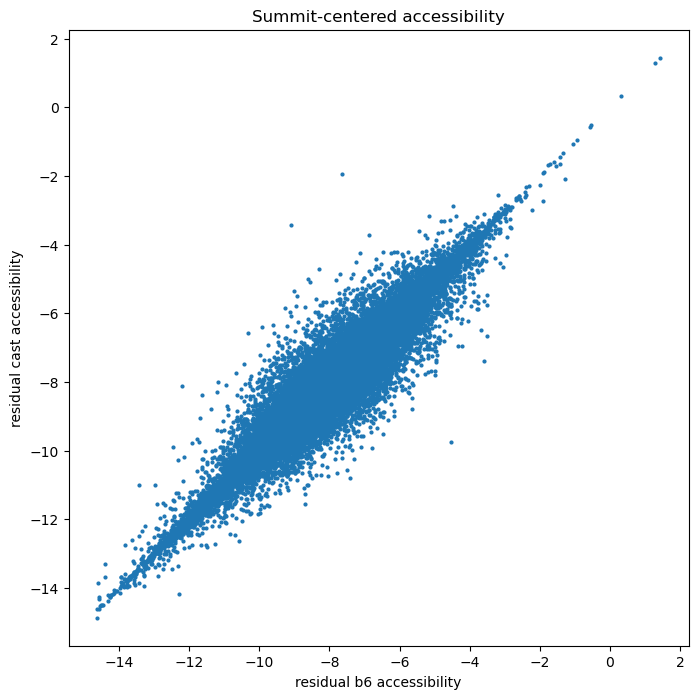

In [20]:
# Regress out GC content
for n in name:
    for allele in ['b6', strain]:
        GC = np.sum(x[n+'_'+allele][:,(seqlen//2-seqlen1//2):(seqlen//2+seqlen1//2),:], axis=1)
        GC = GC[:,1] + GC[:,2]
        y[n+'_'+allele] -= coef*GC

# Visualize GC regressed data
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()

ax.scatter(y['train_b6'], y[f'train_{strain}'],
            vmax = 2, vmin = -2, s = 4)
plt.title('Summit-centered accessibility')
ax.set_xlabel('residual b6 accessibility')
ax.set_ylabel(f'residual {strain} accessibility')
plt.show()